In [140]:
import networkx as nx
import yaml
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
# Load the config file.
print('Loading config file... ', end='')
with open('config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
print('Done!')

# allocate the variables
people = config['people']
books = config['books']
interests = config['interests']
source = config['source']
sink = config['sink']

# fixed capacities for point B
book_copies = config['book_copies']

# check by printing
print('People:', people)
print('Books:', books)
print('Interests:', interests)
print('Source:', source)
print('Sink:', sink)
print('Book copies:', book_copies)

Loading config file... Done!
People: ['p1', 'p2', 'p3', 'p4']
Books: ['b1', 'b2', 'b3', 'b4']
Interests: {'p1': ['b1', 'b2'], 'p2': ['b2', 'b3'], 'p3': ['b1', 'b4'], 'p4': ['b1', 'b2', 'b4']}
Source: o
Sink: d
Book copies: {'b1': 2, 'b2': 3, 'b3': 2, 'b4': 2}


(a) Find a perfect matching using max-flow.
Creating and saving graph... Done!


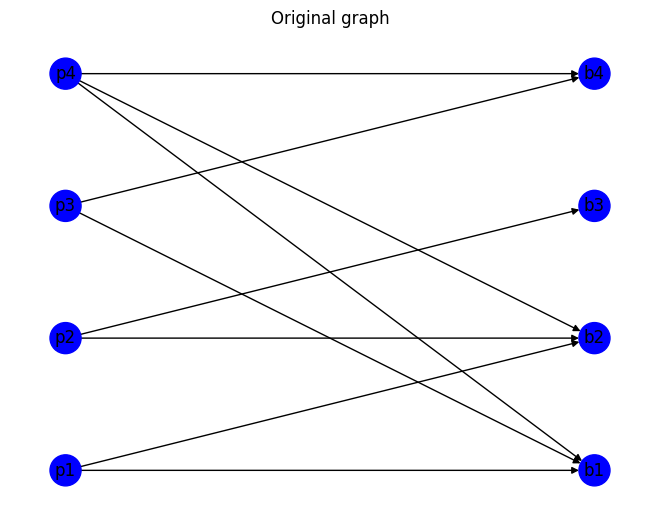

Adding source and sink nodes... Done!
Setting capacity to each edge... Done!
Updating edge flows... Done!


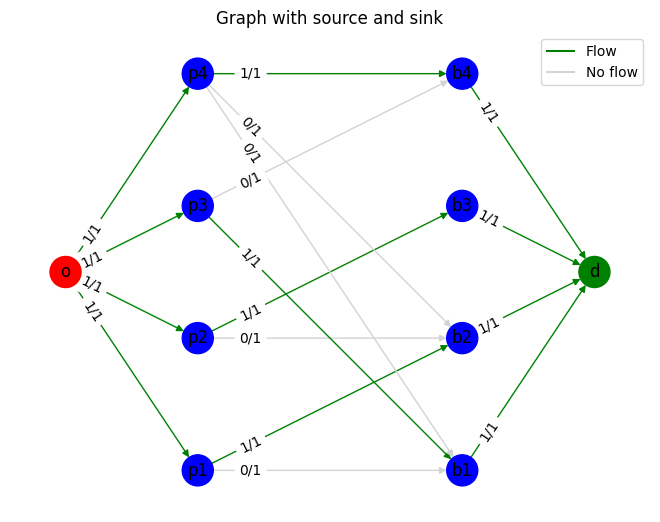

A perfect matching exists.
Here you can see an example of a perfect matching:


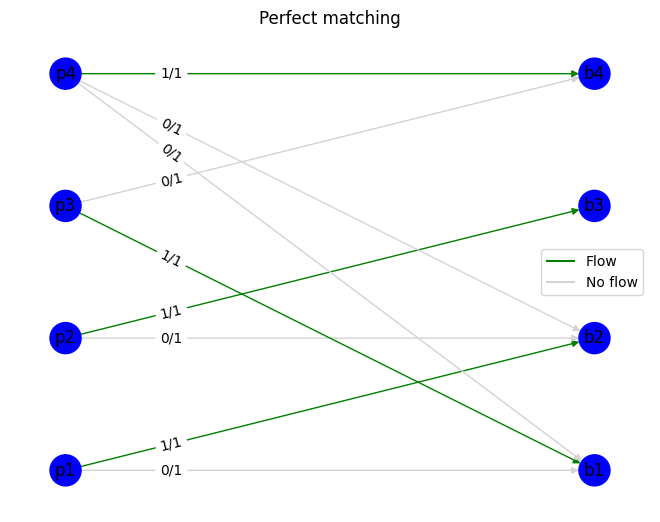

In [142]:
# (a) Find a perfect matching using max-flow.
print("(a) Find a perfect matching using max-flow.")

# Create a directed graph.
if os.path.exists("graph/point_a/initial_graph.png"):
    print("Loading graph from file... ", end="")
    G = load_G("graph/point_a/initial_graph.png")
    print("Done!")
else:
    print("Creating and saving graph... ", end="")
    G = create_G(people, books, interests)
    save_G(G, "graph/point_a/initial_graph.png")
    print("Done!")

# Draw original graph.
draw_G(G, title="Original graph",
       path="plots/point_a/original_graph.png")

# Add source and sink nodes.
print("Adding source and sink nodes... ", end="")
add_source_sink(G, people, books)
print("Done!")

# set 1 of capacity to each edge
print("Setting capacity to each edge... ", end="")
nx.set_edge_attributes(G, 1, 'capacity')
print("Done!")

# update edge flows
print("Updating edge flows... ", end="")
edge_flows = update_edge_flows(G)
print("Done!")

# draw the graph
draw_all_G(G, title="Graph with source and sink",
       path="plots/point_a/graph_with_source_sink.png")

# Find the maximum flow
flow_value = nx.maximum_flow_value(G,source, sink)

# Check if a perfect matching exists
if flow_value == len(people):
    print("A perfect matching exists.")
else:
    print("No perfect matching exists.")

# remove source and sink
remove_source_sink(G)

# draw the graph
print("Here you can see an example of a perfect matching:")
draw_all_G(G, title = "Perfect matching", path="plots/point_a/perfect_matching.png")

# (b) Find the maximum number of assigned books.
Creating and saving graph... Done!
Setting capacities... Done!
Updating edge flows... Done!
Maximum number of assigned books: 8


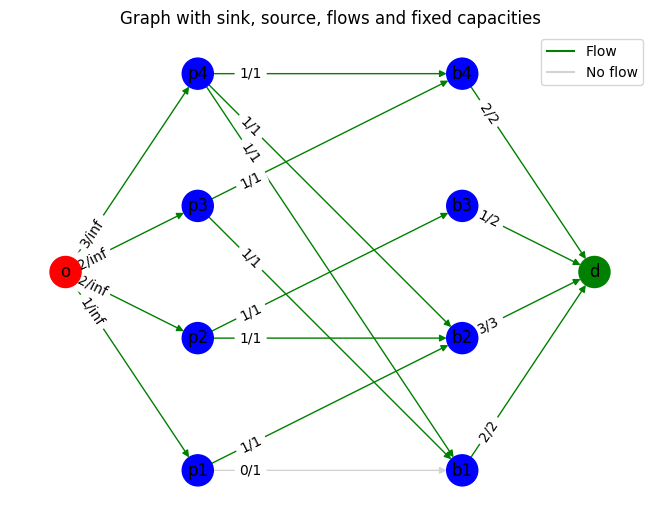

Removing source and sink... Done!


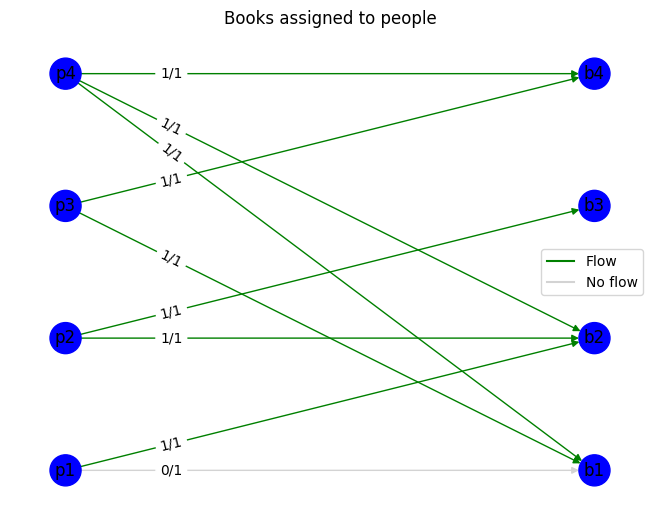

In [143]:
# (b) Find the maximum number of assigned books.
print("# (b) Find the maximum number of assigned books.")
# Create a new graph with capacities.

if os.path.exists("graph/point_b/initial_graph.png"):
    print("Loading graph from file... ", end="")
    G = load_G("graph/point_b/initial_graph.png")
    print("Done!")
else:
    print("Creating and saving graph... ", end="")
    G = create_G(people, books, interests)
    save_G(G, "graph/point_b/initial_graph.png")
    print("Done!")

# add source and sink
add_source_sink(G, people, books)

# Set up edges capacities:
# from source to people: infinite, 
# from people to books: 1, 
# from books to sink: number of book's copies
print("Setting capacities... ", end="")
nx.set_edge_attributes(G, 1, 'capacity')
person_capacities = {(source, person): float('inf') for person in people} 
book_capacities = {(book, sink): book_copies[book] for book in books}

# update edge capacities according to instructions
nx.set_edge_attributes(G, book_capacities, 'capacity')
nx.set_edge_attributes(G, person_capacities, 'capacity')
print("Done!")


# update edge flows
print("Updating edge flows... ", end="")
update_edge_flows(G)
print("Done!")

# Find the maximum flow with capacities
flow_value = nx.maximum_flow_value(G, source, sink)

print("Maximum number of assigned books:", flow_value)

# draw graph with capacities and flows
draw_all_G(G, title = "Graph with sink, source, flows and fixed capacities", 
           path="plots/point_b/sink_source_graph.png")

# save for point C:
save_G(G, "graph/point_c/initial_graph.gml")

# remove source and sink
print("Removing source and sink... ", end="")
remove_source_sink(G)
print("Done!")

# draw graph with capacities and flows
draw_all_G(G, title="Books assigned to people", 
           path="plots/point_b/assigned_books.png")

# (c) Find the books to sell and buy to maximize the number of assigned books.
Loading graph from file... Done!


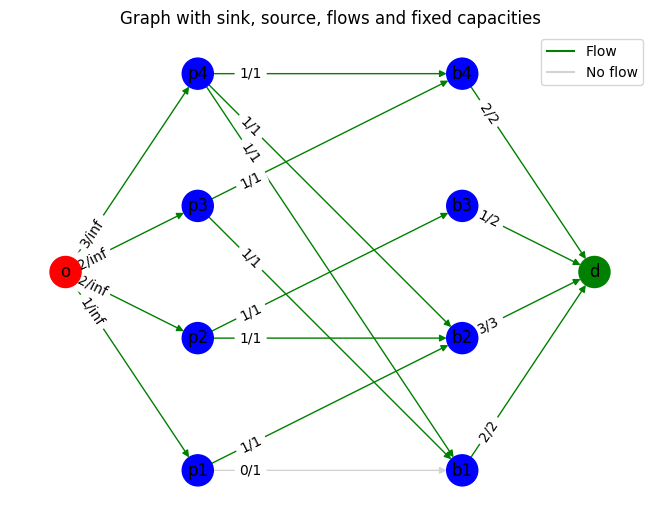

Maximum number of assigned books: 8
Book to sell: b3, ('b3', 'd') = 1/2
Book to buy: b1, ('p1', 'b1') = 0/1
Updating capacities... Done!
Updating edge flows... Done!


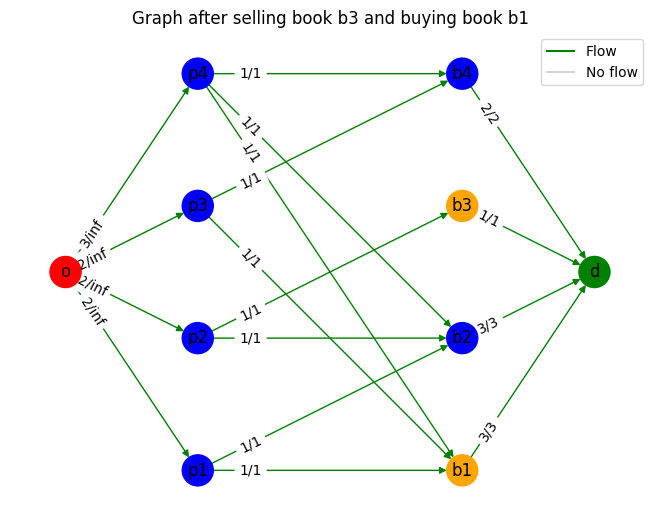

Maximum number of assigned books: 9


In [144]:
# (c) Find the books to sell and buy to maximize the number of assigned books
print("# (c) Find the books to sell and buy to maximize the number of assigned books.")

# load the graph:
print("Loading graph from file... ", end="")
G = load_G("graph/point_c/initial_graph.gml")
print("Done!")
draw_all_G(G, title = "Graph with sink, source, flows and fixed capacities",
           path="plots/point_c/sink_source_graph.png")

# calculate the maximum flow
flow_value = nx.maximum_flow_value(G, source, sink)
print("Maximum number of assigned books:", flow_value)

# We want to sell books that don't use all the capacity on the outgoing edge.
capacities = nx.get_edge_attributes(G, 'capacity')
flows = nx.get_edge_attributes(G, 'flow')

# Check if there is a book to sell.
sold = None
for edge in G.edges():
    if capacities[edge] > flows[edge] and edge[1] == sink:
        G[edge[0]][edge[1]]['capacity'] -= 1
        sold = edge[0]
        break
if not sold:
    raise Exception("No book to sell found.")
print(f"Book to sell: {sold}, {edge} = {flows[edge]}/{capacities[edge]}")

# We want to buy a book for which at least an incoming edge is not saturated:
# Check if there is a book to buy.
bought = None
for edge in G.edges():
    if capacities[edge] > flows[edge] and edge[1] in books:
        G[edge[1]][sink]['capacity'] += 1
        bought = edge[1]
        break
if not bought:
    raise Exception("No book to buy found.")
print(f"Book to buy: {bought}, {edge} = {flows[edge]}/{capacities[edge]}")

# update node colors
nx.set_node_attributes(G, {sold:'orange', bought:'orange'}, 'color')

# Update edge flows.
print("Updating capacities... Done!")
print("Updating edge flows... ", end="")
update_edge_flows(G)
print("Done!")

# Draw graph with capacities and flows.
draw_all_G(G, title = f"Graph after selling book {sold} and buying book {bought}",
           path="plots/point_c/sell_buy.png")

# Print the new maximum flow value.
flow_value = nx.maximum_flow_value(G, source, sink)
print("Maximum number of assigned books:", flow_value)